# Notebook per pre-elaborazione dei dati

Di seguito:
- verranno prelevati i dati e resi disponibili su variabili;
- saranno effettuate operazioni sui dati per avvicinarsi a distribuzioni gaussiane;
- verranno create nuove feature create a partire da quelle presenti e sarà valutata la loro significatività

## Scaricamento dei dati

In [3]:
# File per scaricare i dati per fare analisi di machine learning

import requests
import zipfile
import io
import os

# List of URLs to your zipped files on AWS
urls = [
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip",
    "https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip",
]

# Directory to save the extracted files
output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True)

for url in urls:
    try:
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        response.raise_for_status() # Raise an exception for bad status codes

        # Read the zip file from the response content
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extract all contents to the specified output directory
            zip_ref.extractall(output_dir)
            print(f"Extracted files from {url} to {output_dir}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading {url}: {e}")
    except zipfile.BadZipFile:
        print(f"Error: The downloaded file from {url} is not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

print("Download and extraction complete.")

# Now you can access your CSV files in the 'downloaded_data' directory
# For example, to list the files in the directory:
import glob
csv_files = glob.glob(os.path.join(output_dir, "*.csv"))
print("CSV files found:", csv_files)

Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_training_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_validation_data.zip to dataset
Extracted files from https://phm-datasets.s3.amazonaws.com/Data_Challenge_PHM2024_test_data.zip to dataset
Download and extraction complete.
CSV files found: ['dataset/X_validation.csv', 'dataset/X_test.csv', 'dataset/X_train.csv', 'dataset/y_train.csv']


## Creazione variabile dati di training

Prendo i dati di train dalla cartella e creo la variabile contenente tutti i dati e lo stato di salute delle turbine.

In [4]:
import pandas as pd

def load_training_data(x_path, y_path):
  """
  Loads X_train.csv and the second column of y_train.csv into a single pandas DataFrame.

  Args:
    x_path (str): The path to the X_train.csv file.
    y_path (str): The path to the y_train.csv file.

  Returns:
    pandas.DataFrame: A DataFrame containing the data from X_train.csv
                      and the second column of y_train.csv.
  """
  x_train = pd.read_csv(x_path)
  y_train = pd.read_csv(y_path)

  # Assuming y_train has at least 2 columns and the second column is at index 1
  if y_train.shape[1] > 1:
    combined_data = x_train.copy()
    combined_data['y_target'] = y_train.iloc[:, 1]
    return combined_data
  else:
    print("Error: y_train.csv does not have a second column.")
    return x_train

# Example usage:
# Assuming your files are in the 'dataset' directory as per the preceding code
x_train_path = 'dataset/X_train.csv'
y_train_path = 'dataset/y_train.csv'

data_train = load_training_data(x_train_path, y_train_path)

# You can now work with the 'training_data' DataFrame
print(data_train.head())


   id  trq_measured       oat       mgt         pa       ias         np  \
0   0        54.100   2.00000  544.5000   212.1408  74.56250   89.18000   
1   1        49.625  24.22231  578.4844  1625.6400  30.35596   99.55273   
2   2        52.000   7.00000  566.1000  1912.9250  65.62500  100.14000   
3   3        62.400   7.25000  560.1000   277.0632  54.81250   90.64000   
4   4        62.900  23.25000  593.7000    53.6448  73.43750   99.91000   

         ng  y_target  
0   99.6400         1  
1   91.3866         0  
2   90.9600         1  
3  100.2800         0  
4   92.1700         0  


## Cambio dei nomi delle feature

In [5]:
def rename_dataframe_columns(df, new_column_names):
  """
  Renames the columns of a pandas DataFrame.

  Args:
    df: The pandas DataFrame whose columns are to be renamed.
    new_column_names: A list of new column names. The length of this list
                      must match the number of columns in the DataFrame.

  Returns:
    The DataFrame with renamed columns.
  """
  if len(new_column_names) != len(df.columns):
    raise ValueError("The number of new column names must match the number of existing columns.")
  df.columns = new_column_names
  return df

# Example usage:
# Assuming you have a list of new names for your columns
new_names_for_train_data = ['idx', 'torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed', 'health_state'] # Replace with your desired names

# Rename the columns of data_train
# Ensure the number of names in new_names_for_train_data matches the number of columns in data_train
print(f"Number of columns in data_train: {len(data_train.columns)}")
print(f"Number of new names provided: {len(new_names_for_train_data)}")

data_train = rename_dataframe_columns(data_train, new_names_for_train_data)
print("\nDataFrame after renaming columns:")
print(data_train.head())

Number of columns in data_train: 9
Number of new names provided: 9

DataFrame after renaming columns:
   idx  torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
0    0       54.100           2.00000       544.5000     212.1408   
1    1       49.625          24.22231       578.4844    1625.6400   
2    2       52.000           7.00000       566.1000    1912.9250   
3    3       62.400           7.25000       560.1000     277.0632   
4    4       62.900          23.25000       593.7000      53.6448   

   indicated_air_speed  net_power  compressor_speed  health_state  
0             74.56250   89.18000           99.6400             1  
1             30.35596   99.55273           91.3866             0  
2             65.62500  100.14000           90.9600             1  
3             54.81250   90.64000          100.2800             0  
4             73.43750   99.91000           92.1700             0  


## Esplorazione dati

In [6]:
print("Informazioni di base sulle colonne:")
print(data_train.info())

print("\Statistiche descrittive delle colonne:")
print(data_train.describe())

Informazioni di base sulle colonne:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742625 entries, 0 to 742624
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   idx                  742625 non-null  int64  
 1   torque_meas          742625 non-null  float64
 2   outside_air_temp     742625 non-null  float64
 3   mean_gas_temp        742625 non-null  float64
 4   power_avail          742625 non-null  float64
 5   indicated_air_speed  742625 non-null  float64
 6   net_power            742625 non-null  float64
 7   compressor_speed     742625 non-null  float64
 8   health_state         742625 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 51.0 MB
None
\Statistiche descrittive delle colonne:
                 idx    torque_meas  outside_air_temp  mean_gas_temp  \
count  742625.000000  742625.000000     742625.000000  742625.000000   
mean   371312.000000      65.097549         12.675167

## Standardizzazione

In [9]:
from sklearn.preprocessing import MinMaxScaler

def standardize_columns(df, columns_to_standardize):
  """
  Standardizes specified columns of a pandas DataFrame to have values between 0 and 1
  using MinMaxScaler.

  Args:
    df: The pandas DataFrame to standardize.
    columns_to_standardize: A list of column names to standardize.

  Returns:
    The DataFrame with the specified columns standardized.
  """
  scaler = MinMaxScaler()
  df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
  return df

# Example usage:
# Assuming you want to standardize all numerical columns except the index and the target variable
# Identify numerical columns (excluding 'idx' and 'health_state' in this case)
numerical_cols = data_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
columns_to_standardize = [col for col in numerical_cols if col not in ['idx', 'health_state']]

print(f"\nColumns to standardize: {columns_to_standardize}")

data_train_standardized = standardize_columns(data_train.copy(), columns_to_standardize)

print("\nDataFrame after standardization:")
print(data_train_standardized.head())
print("\nDescriptive statistics after standardization:")
print(data_train_standardized.describe())


Columns to standardize: ['torque_meas', 'outside_air_temp', 'mean_gas_temp', 'power_avail', 'indicated_air_speed', 'net_power', 'compressor_speed']

DataFrame after standardization:
   idx  torque_meas  outside_air_temp  mean_gas_temp  power_avail  \
0    0     0.437796          0.379132       0.301445     0.127206   
1    1     0.388105          0.775611       0.434144     0.554775   
2    2     0.414477          0.468339       0.385787     0.641675   
3    3     0.529960          0.472799       0.362358     0.146844   
4    4     0.535512          0.758263       0.493557     0.079263   

   indicated_air_speed  net_power  compressor_speed  health_state  
0             0.542026   0.251964          0.859157             1  
1             0.220670   0.878715          0.123440             0  
2             0.477056   0.914199          0.085412             1  
3             0.398455   0.340181          0.916207             0  
4             0.533848   0.900302          0.193273           

## Power available

Ha un andamento che tende a sinistra, quindi con coda a destra (right skewed), infatti la media è maggiore della mediana

### Logaritmo

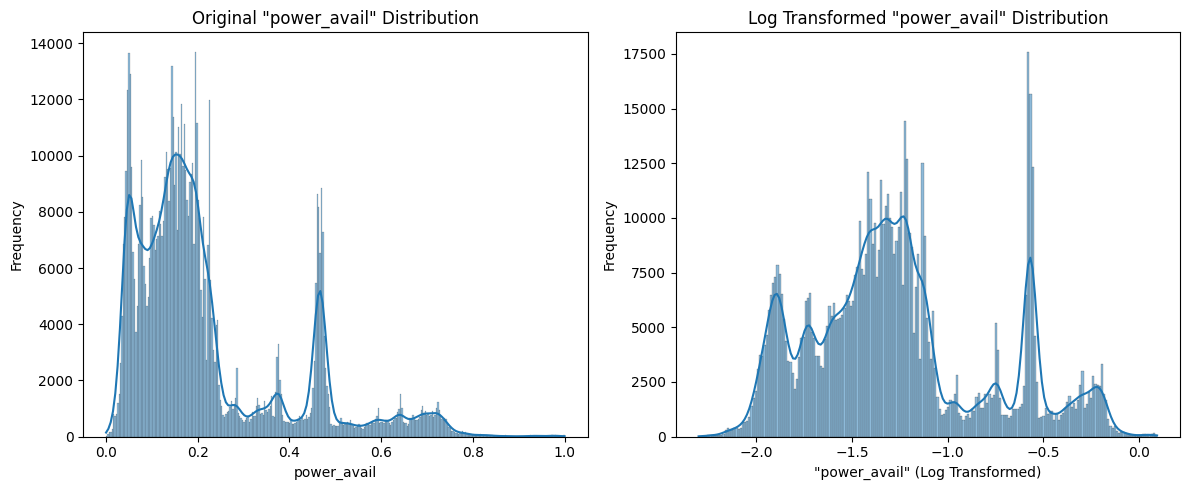


Descriptive statistics for original and transformed 'power_avail':
         power_avail  power_avail_log_transformed
count  742625.000000                742625.000000
mean        0.217842                    -1.264275
std         0.170359                     0.468485
min         0.000000                    -2.302585
25%         0.103972                    -1.589773
50%         0.166022                    -1.324178
75%         0.240979                    -1.075934
max         1.000000                     0.095310


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def transform_right_skewed(df, column_name):
  """
  Applies a logarithmic transformation to a right-skewed column to make it more Gaussian-like.
  Handles zero and negative values by adding a small constant.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  # Add a small constant to handle zero or negative values before log transform
  # This constant is often the absolute value of the minimum plus a small epsilon
  min_val = df[column_name].min()
  if min_val <= 0:
      constant = abs(min_val) + 1e-1
      df[f'{column_name}_log_transformed'] = np.log(df[column_name] + constant)
  else:
      df[f'{column_name}_log_transformed'] = np.log(df[column_name])

  return df

# Apply the transformation to the 'power_avail' column
data_train_standardized = transform_right_skewed(data_train_standardized.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train_standardized['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram
plt.subplot(1, 2, 2)
sns.histplot(data_train_standardized['power_avail_log_transformed'], kde=True)
plt.title('Log Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Log Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and transformed 'power_avail':")
print(data_train_standardized[['power_avail', 'power_avail_log_transformed']].describe())


### Radice quadrata

Trasformando i dati con la radice quadrata sono stati ottenuti valori più centrati, la media è più vicina alla mediana di prima.

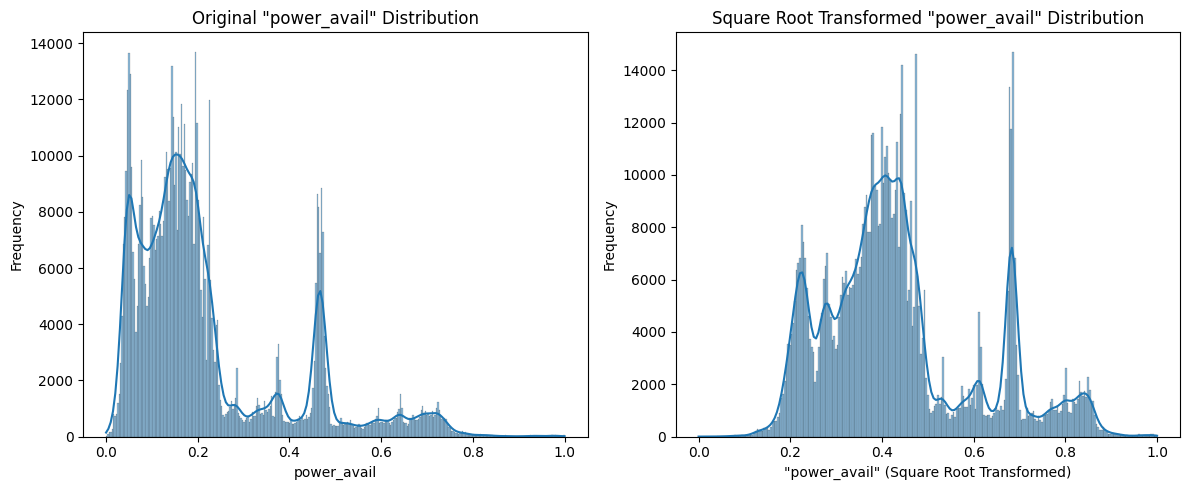


Descriptive statistics for original and sqrt transformed 'power_avail':
         power_avail  power_avail_sqrt_transformed
count  742625.000000                 742625.000000
mean        0.217842                      0.435868
std         0.170359                      0.166919
min         0.000000                      0.000000
25%         0.103972                      0.322447
50%         0.166022                      0.407458
75%         0.240979                      0.490896
max         1.000000                      1.000000


In [12]:
def transform_with_sqrt(df, column_name):
  """
  Applies a square root transformation to a column.
  Ensures values are non-negative before applying the square root.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  # Ensure values are non-negative before applying square root
  # You might want to handle negative values differently based on your data context
  if (df[column_name] < 0).any():
      print(f"Warning: Column '{column_name}' contains negative values. Applying sqrt to absolute values.")
      df[f'{column_name}_sqrt_transformed'] = np.sqrt(np.abs(df[column_name]))
  else:
      df[f'{column_name}_sqrt_transformed'] = np.sqrt(df[column_name])

  return df

# Apply the square root transformation to the 'power_avail' column
data_train_standardized = transform_with_sqrt(data_train_standardized.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train_standardized['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Square Root)
plt.subplot(1, 2, 2)
sns.histplot(data_train_standardized['power_avail_sqrt_transformed'], kde=True)
plt.title('Square Root Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Square Root Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and sqrt transformed 'power_avail':")
print(data_train_standardized[['power_avail', 'power_avail_sqrt_transformed']].describe())

### Radice cubica

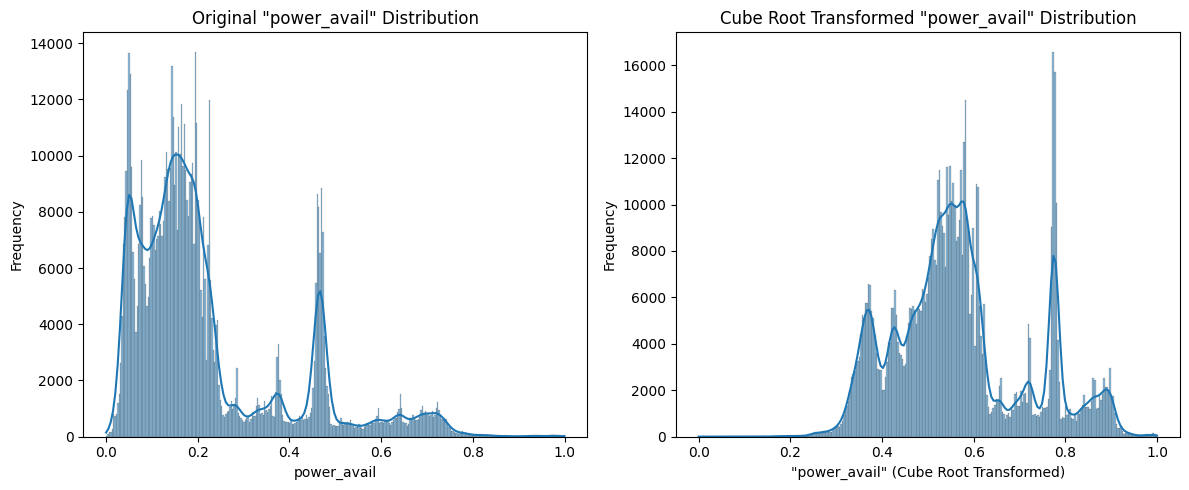


Descriptive statistics for original and cbrt transformed 'power_avail':
         power_avail  power_avail_cbrt_transformed
count  742625.000000                 742625.000000
mean        0.217842                      0.565868
std         0.170359                      0.143851
min         0.000000                      0.000000
25%         0.103972                      0.470224
50%         0.166022                      0.549610
75%         0.240979                      0.622291
max         1.000000                      1.000000


In [13]:
def transform_with_cbrt(df, column_name):
  """
  Applies a cube root transformation to a column.
  The cube root can handle positive, negative, and zero values.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_cbrt_transformed'] = np.cbrt(df[column_name])
  return df

# Apply the cube root transformation to the 'power_avail' column
data_train_standardized = transform_with_cbrt(data_train_standardized.copy(), 'power_avail')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train_standardized['power_avail'], kde=True)
plt.title('Original "power_avail" Distribution')
plt.xlabel('power_avail')
plt.ylabel('Frequency')

# Transformed histogram (Cube Root)
plt.subplot(1, 2, 2)
sns.histplot(data_train_standardized['power_avail_cbrt_transformed'], kde=True)
plt.title('Cube Root Transformed "power_avail" Distribution')
plt.xlabel('"power_avail" (Cube Root Transformed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and cbrt transformed 'power_avail':")
print(data_train_standardized[['power_avail', 'power_avail_cbrt_transformed']].describe())

## Indicated Air Speed
La variabile indicated_air_speed ha un picco molto a destra, quindi una coda a sinistra (left skewed), infatti ha una media minore della mediana

### Elevamento al quadrato

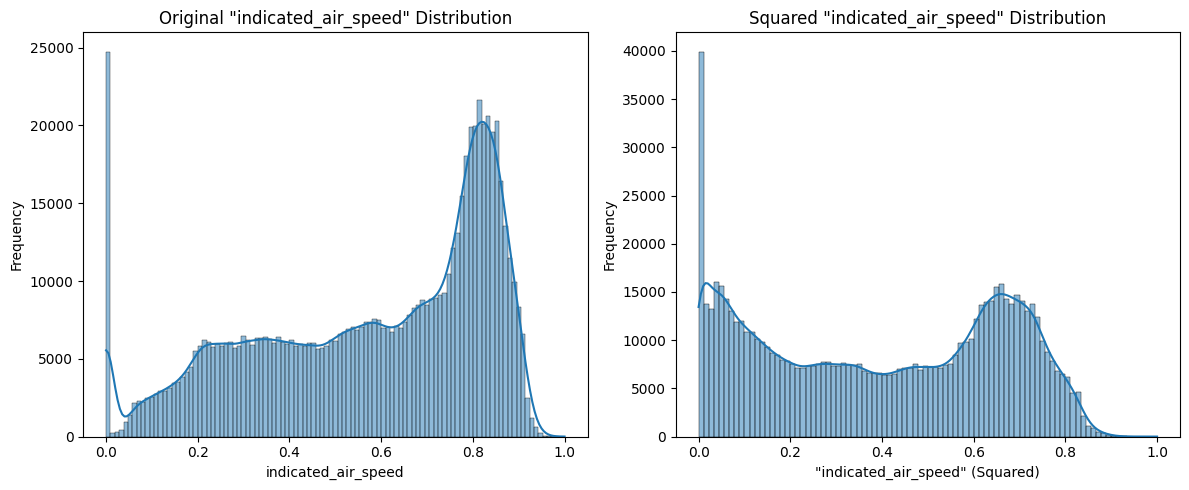


Descriptive statistics for original and squared 'indicated_air_speed':
       indicated_air_speed  indicated_air_speed_squared
count        742625.000000                742625.000000
mean              0.576644                     0.398722
std               0.257302                     0.263781
min               0.000000                     0.000000
25%               0.371649                     0.138123
50%               0.642435                     0.412723
75%               0.803726                     0.645975
max               1.000000                     1.000000


In [15]:
def transform_with_square(df, column_name):
  """
  Applies a square transformation to a column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_squared'] = df[column_name] ** 2
  return df

# Apply the square transformation to the 'indicated_air_speed' column
data_train_standardized = transform_with_square(data_train_standardized.copy(), 'indicated_air_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train_standardized['indicated_air_speed'], kde=True)
plt.title('Original "indicated_air_speed" Distribution')
plt.xlabel('indicated_air_speed')
plt.ylabel('Frequency')

# Transformed histogram (Squared)
plt.subplot(1, 2, 2)
sns.histplot(data_train_standardized['indicated_air_speed_squared'], kde=True)
plt.title('Squared "indicated_air_speed" Distribution')
plt.xlabel('"indicated_air_speed" (Squared)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and squared 'indicated_air_speed':")
print(data_train_standardized[['indicated_air_speed', 'indicated_air_speed_squared']].describe())


### Elevamento al cubo

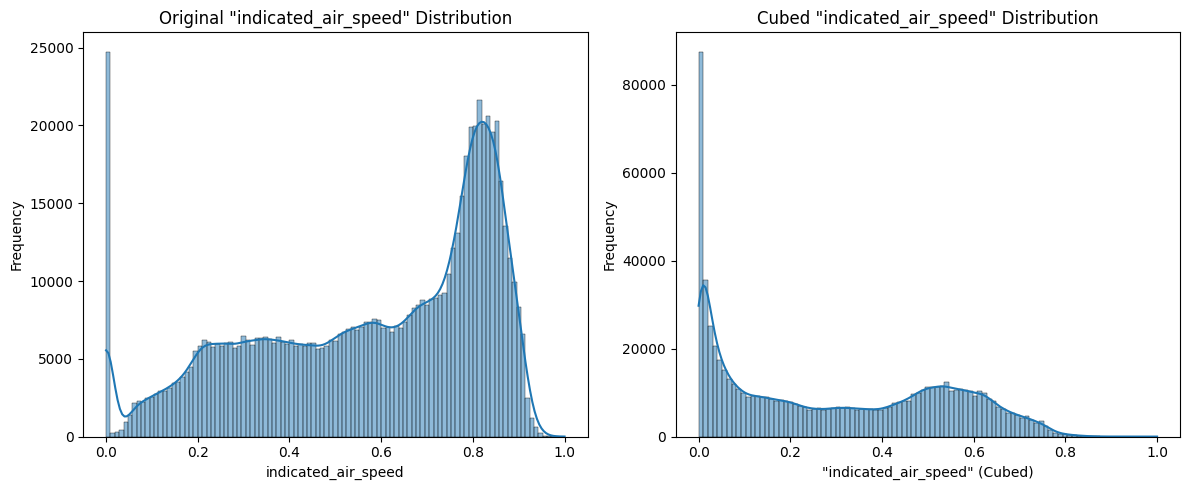


Descriptive statistics for original and cubed 'indicated_air_speed':
       indicated_air_speed  indicated_air_speed_cubed
count        742625.000000              742625.000000
mean              0.576644                   0.295999
std               0.257302                   0.240692
min               0.000000                   0.000000
25%               0.371649                   0.051333
50%               0.642435                   0.265148
75%               0.803726                   0.519186
max               1.000000                   1.000000


In [17]:
def transform_with_cube(df, column_name):
  """
  Applies a cube transformation to a column.

  Args:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to transform.

  Returns:
    pd.DataFrame: The DataFrame with the transformed column.
  """
  df[f'{column_name}_cubed'] = df[column_name] ** 3
  return df

# Apply the cube transformation to the 'indicated_air_speed' column
data_train_standardized = transform_with_cube(data_train_standardized.copy(), 'indicated_air_speed')

# Plot histograms before and after transformation
plt.figure(figsize=(12, 5))

# Original histogram
plt.subplot(1, 2, 1)
sns.histplot(data_train_standardized['indicated_air_speed'], kde=True)
plt.title('Original "indicated_air_speed" Distribution')
plt.xlabel('indicated_air_speed')
plt.ylabel('Frequency')

# Transformed histogram (Cubed)
plt.subplot(1, 2, 2)
sns.histplot(data_train_standardized['indicated_air_speed_cubed'], kde=True)
plt.title('Cubed "indicated_air_speed" Distribution')
plt.xlabel('"indicated_air_speed" (Cubed)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\nDescriptive statistics for original and cubed 'indicated_air_speed':")
print(data_train_standardized[['indicated_air_speed', 'indicated_air_speed_cubed']].describe())


### Air speed 0
Noto che ci sono tanti valori con indicated air speed nulla, vorrei cercare di indagare per capire meglio in che condizioni si verifica

In [19]:
# prompt: indicated_air_speed ha un sacco di valori nulli, vorrei fare una variabile che contenga una copia di tutti i valori di tutte le colonne in corrispondenza di indicated_air_speed = 0 per data train standardize. vorrei torque meas, outside temperature, mean gas temperature, power_avail_sqrt_transformed, indicated air speed, net_power, compressor_speed, health_state

# Filter the DataFrame where 'indicated_air_speed' is 0
indicated_air_speed_zero_data = data_train_standardized[data_train_standardized['indicated_air_speed'] == 0].copy()

# Select the specified columns
selected_columns_at_zero_speed = indicated_air_speed_zero_data[[
    'torque_meas',
    'outside_air_temp',
    'mean_gas_temp',
    'power_avail_sqrt_transformed',
    'indicated_air_speed',
    'net_power',
    'compressor_speed',
    'health_state'
]]

# Display the head of the new DataFrame
print("\nData where 'indicated_air_speed' is 0 for selected columns:")
print(selected_columns_at_zero_speed.head())

# Display descriptive statistics for these columns when speed is zero
print("\nDescriptive statistics for selected columns where 'indicated_air_speed' is 0:")
print(selected_columns_at_zero_speed.describe())


Data where 'indicated_air_speed' is 0 for selected columns:
     torque_meas  outside_air_temp  mean_gas_temp  \
34      0.670981          0.597690       0.660289   
82      0.669871          0.860852       0.762593   
84      0.637669          0.655675       0.605232   
179     0.591032          0.615531       0.550176   
185     0.472219          0.776105       0.492386   

     power_avail_sqrt_transformed  indicated_air_speed  net_power  \
34                       0.367105                  0.0   0.648338   
82                       0.387509                  0.0   0.894864   
84                       0.294501                  0.0   0.893656   
179                      0.393412                  0.0   0.893051   
185                      0.152636                  0.0   0.407855   

     compressor_speed  health_state  
34           0.925121             0  
82           0.595299             1  
84           0.351053             1  
179          0.332333             1  
185          0.


Histograms of variables when 'indicated_air_speed' is 0:


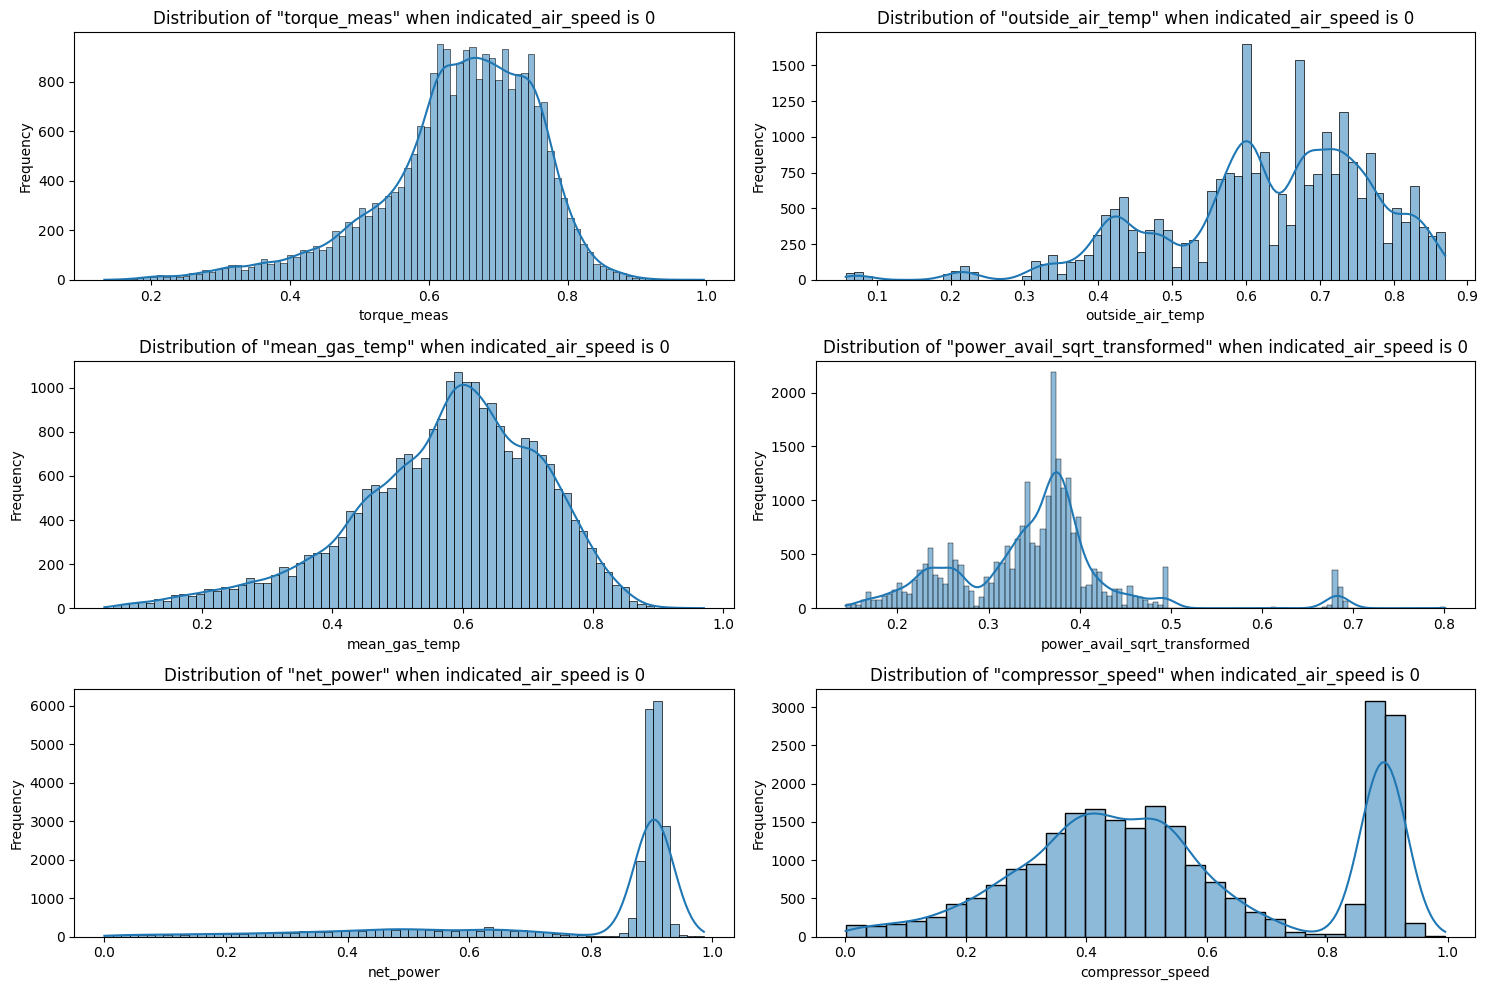


Relationship between selected variables and 'health_state' when 'indicated_air_speed' is 0:


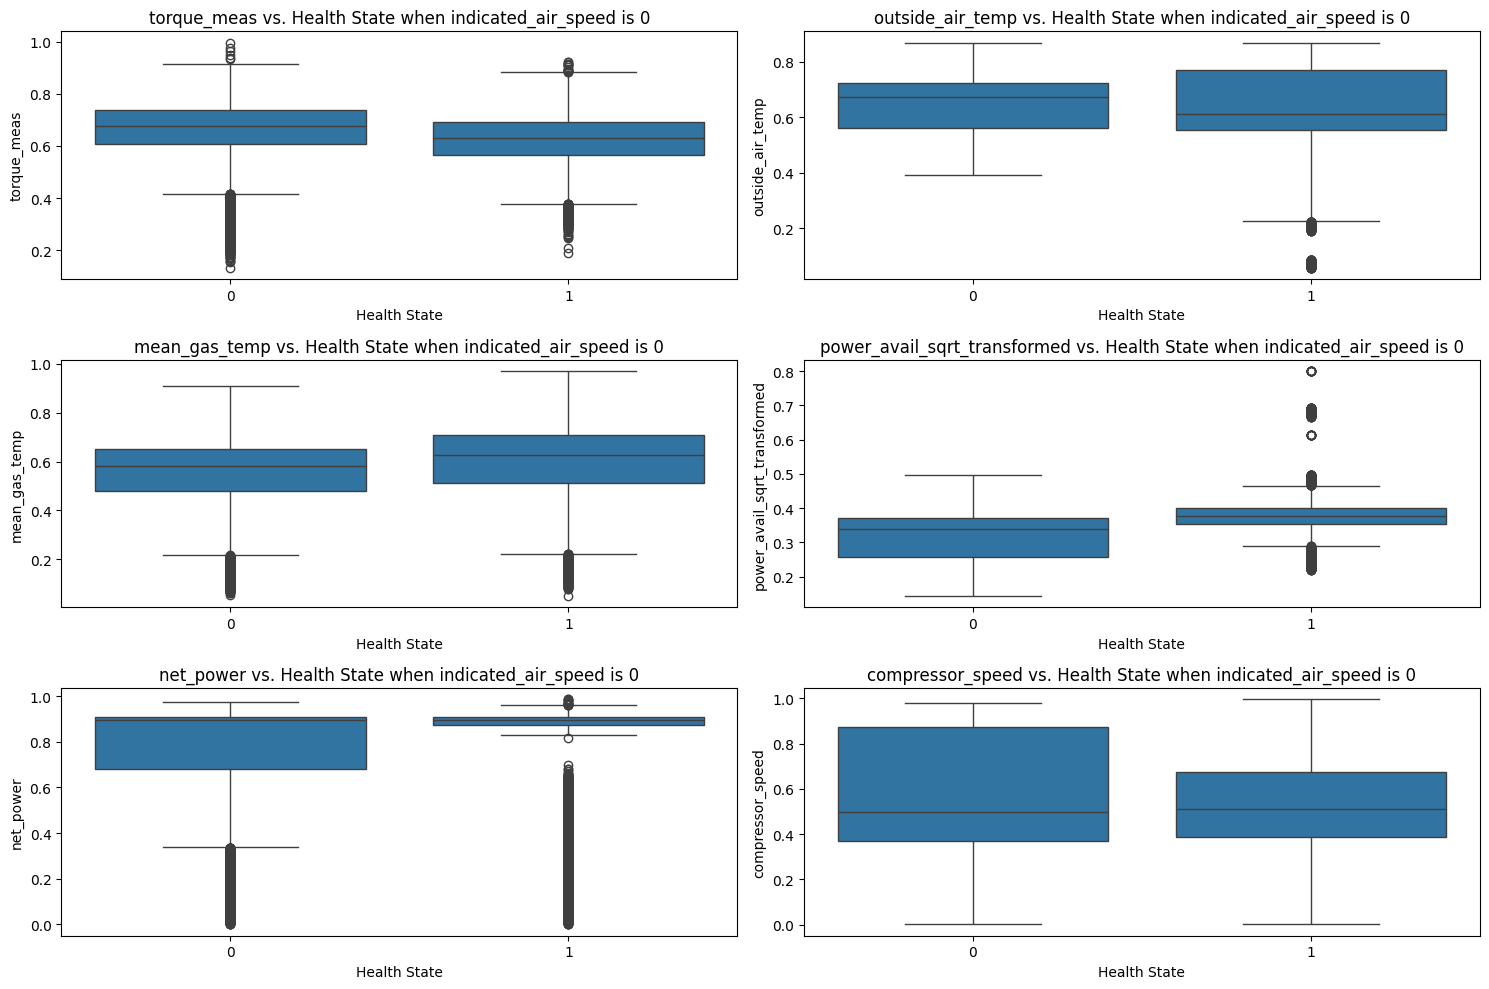


Distribution of 'health_state' when 'indicated_air_speed' is 0:
health_state
0    15235
1     9283
Name: count, dtype: int64

Correlation matrix for selected variables when 'indicated_air_speed' is 0:


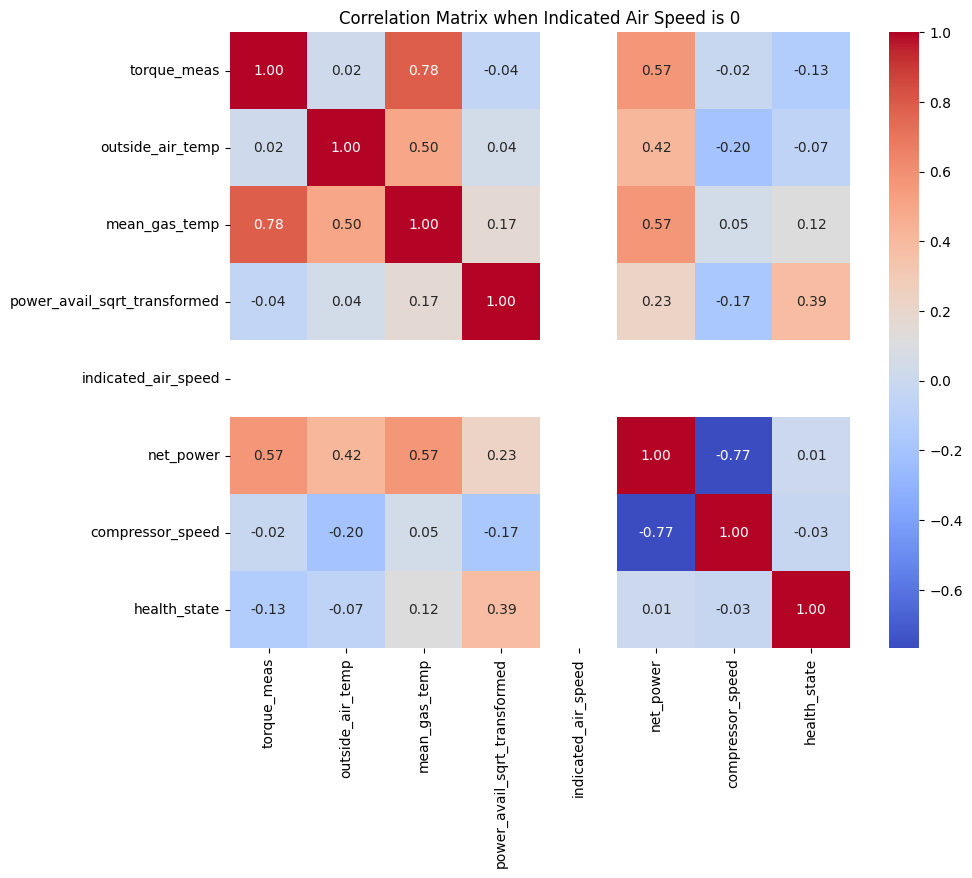

In [21]:
# Analyze the distribution of other variables when indicated_air_speed is zero

# Plotting histograms for relevant columns when indicated_air_speed is zero
columns_to_plot_at_zero_speed = [
    'torque_meas',
    'outside_air_temp',
    'mean_gas_temp',
    'power_avail_sqrt_transformed', # Using the transformed 'power_avail'
    'net_power',
    'compressor_speed',
]

print("\nHistograms of variables when 'indicated_air_speed' is 0:")
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_plot_at_zero_speed):
    plt.subplot(3, 2, i + 1)
    sns.histplot(selected_columns_at_zero_speed[col], kde=True)
    plt.title(f'Distribution of "{col}" when indicated_air_speed is 0')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Analyze the relationship with 'health_state' when indicated_air_speed is zero
print("\nRelationship between selected variables and 'health_state' when 'indicated_air_speed' is 0:")

# Box plots for numerical variables vs. health_state
plt.figure(figsize=(15, 10))
for i, col in enumerate(columns_to_plot_at_zero_speed):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x='health_state', y=col, data=selected_columns_at_zero_speed)
    plt.title(f'{col} vs. Health State when indicated_air_speed is 0')
    plt.xlabel('Health State')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

# Count of health states when indicated_air_speed is zero
print("\nDistribution of 'health_state' when 'indicated_air_speed' is 0:")
print(selected_columns_at_zero_speed['health_state'].value_counts())

# You could also explore correlations within the indicated_air_speed_zero_data subset
print("\nCorrelation matrix for selected variables when 'indicated_air_speed' is 0:")
correlation_matrix_zero_speed = selected_columns_at_zero_speed.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_zero_speed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix when Indicated Air Speed is 0')
plt.show()